In [91]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from cxroots import Rectangle as cxRectangle
from cxroots.root_approximation import approximate_roots
from tqdm import tqdm

from skzeros._AAA import AAA, poles_residues
from skzeros._domain import Rectangle

plt.style.use("style.mplstyle")

In [92]:
def delves_lyness(f, f_z, domain, N=None, quad_kwargs=None):
    if N is None:
        N = round(
            domain.argument_principle(f, f_z, quadrature_args=quad_kwargs).integral.real
        )
    s = np.empty(N + 1, dtype=np.complex128)
    s[0] = N

    for i in range(1, N + 1):
        s[i] = domain.argument_principle(
            f, lambda z, i=i: (z**i) * f_z(z), quadrature_args=quad_kwargs
        ).integral

    coeffs = np.ones(N + 1, dtype=np.complex128)

    A = scipy.linalg.toeplitz(s[:-1])
    np.fill_diagonal(A, np.arange(1, N + 1))
    A = np.tril(A)
    coeffs[1:] = np.linalg.solve(A, -s[1:])

    return np.roots(coeffs)

In [93]:
def kravanja_van_barel(f, f_z, domain, N=None, quad_kwargs=None):
    if N is None:
        N = round(
            domain.argument_principle(f, f_z, quadrature_args=quad_kwargs).integral.real
        )

    s = np.empty(2 * N, dtype=np.complex128)
    s[0] = N

    for i in range(1, 2 * N):
        s[i] = domain.argument_principle(
            f, lambda z, i=i: (z**i) * f_z(z), quadrature_args=quad_kwargs
        ).integral

    H_N = scipy.linalg.hankel(s[:N], s[N - 1 : -1])
    n = np.linalg.matrix_rank(H_N)

    H_N = scipy.linalg.hankel(s[:n], s[n - 1 : 2 * n - 1])
    H_N_reduced = scipy.linalg.hankel(s[1 : n + 1], s[n : 2 * n])

    zeros = scipy.linalg.eigvals(H_N_reduced, H_N)
    multiplicities = np.linalg.solve(np.vander(zeros, increasing=True).T, s[:n])
    return zeros, multiplicities

In [94]:
d = Rectangle(complex(0, 0), complex(1, 1))
c = cxRectangle((0, 1), (0, 1))

n_zeros = [3, 6, 9, 12]
zeros_sets = [np.linspace(0.1, 0.9, num=n) + 0.5j for n in n_zeros]

In [95]:
delves_lyness_error = []
delves_lyness_function_count = []
kravanja_van_barel_error = []
kravanja_van_barel_function_count = []
kravanja_van_barel_FOP_error = []
kravanja_van_barel_FOP_function_count = []
aaa_error = []
aaa_function_count = []
function_eval_steps = 10


for i in range(4):
    delves_lyness_error_tmp = []
    delves_lyness_function_count_tmp = []
    kravanja_van_barel_error_tmp = []
    kravanja_van_barel_function_count_tmp = []
    kravanja_van_barel_FOP_error_tmp = []
    kravanja_van_barel_FOP_function_count_tmp = []
    aaa_error_tmp = []
    aaa_function_count_tmp = []

    for tol in tqdm(np.logspace(-1, -13, num=function_eval_steps)):
        count = 0

        def f(z, i=i):
            global count  # noqa: PLW0603
            count += getattr(z, "size", 1)
            return np.prod(np.subtract.outer(z, zeros_sets[i]), axis=-1)

        def f_prime(z, i=i):
            return np.prod(np.subtract.outer(z, zeros_sets[i]), axis=-1) * np.sum(
                1 / np.subtract.outer(z, zeros_sets[i]), axis=-1
            )

        result = delves_lyness(
            f, f_prime, d, quad_kwargs={"epsabs": tol, "epsrel": tol}
        )
        error = np.min(np.abs(np.subtract.outer(result, zeros_sets[i])), axis=0)
        delves_lyness_error_tmp.append(np.median(error))
        delves_lyness_function_count_tmp.append(count)

        count = 0
        result = kravanja_van_barel(
            f, f_prime, d, quad_kwargs={"epsabs": tol, "epsrel": tol}
        )[0]
        error = np.min(np.abs(np.subtract.outer(result, zeros_sets[i])), axis=0)
        kravanja_van_barel_error_tmp.append(np.median(error))
        kravanja_van_barel_function_count_tmp.append(count)

        count = 0
        result = approximate_roots(
            c, c.count_roots(f, f_prime), f, f_prime, abs_tol=tol, rel_tol=tol
        )
        error = np.min(np.abs(np.subtract.outer(result[0], zeros_sets[i])), axis=0)
        kravanja_van_barel_FOP_error_tmp.append(np.median(error))
        kravanja_van_barel_FOP_function_count_tmp.append(count)

        count = 0
        result = AAA(lambda z: f_prime(z) / f(z), d, rtol=tol)
        error = np.min(
            np.abs(np.subtract.outer(poles_residues(*result), zeros_sets[i])), axis=0
        )
        aaa_error_tmp.append(np.median(error))
        aaa_function_count_tmp.append(count)

    delves_lyness_error.append(delves_lyness_error_tmp)
    delves_lyness_function_count.append(delves_lyness_function_count_tmp)
    kravanja_van_barel_error.append(kravanja_van_barel_error_tmp)
    kravanja_van_barel_function_count.append(kravanja_van_barel_function_count_tmp)
    kravanja_van_barel_FOP_error.append(kravanja_van_barel_FOP_error_tmp)
    kravanja_van_barel_FOP_function_count.append(
        kravanja_van_barel_FOP_function_count_tmp
    )
    aaa_function_count.append(aaa_function_count_tmp)
    aaa_error.append(aaa_error_tmp)

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


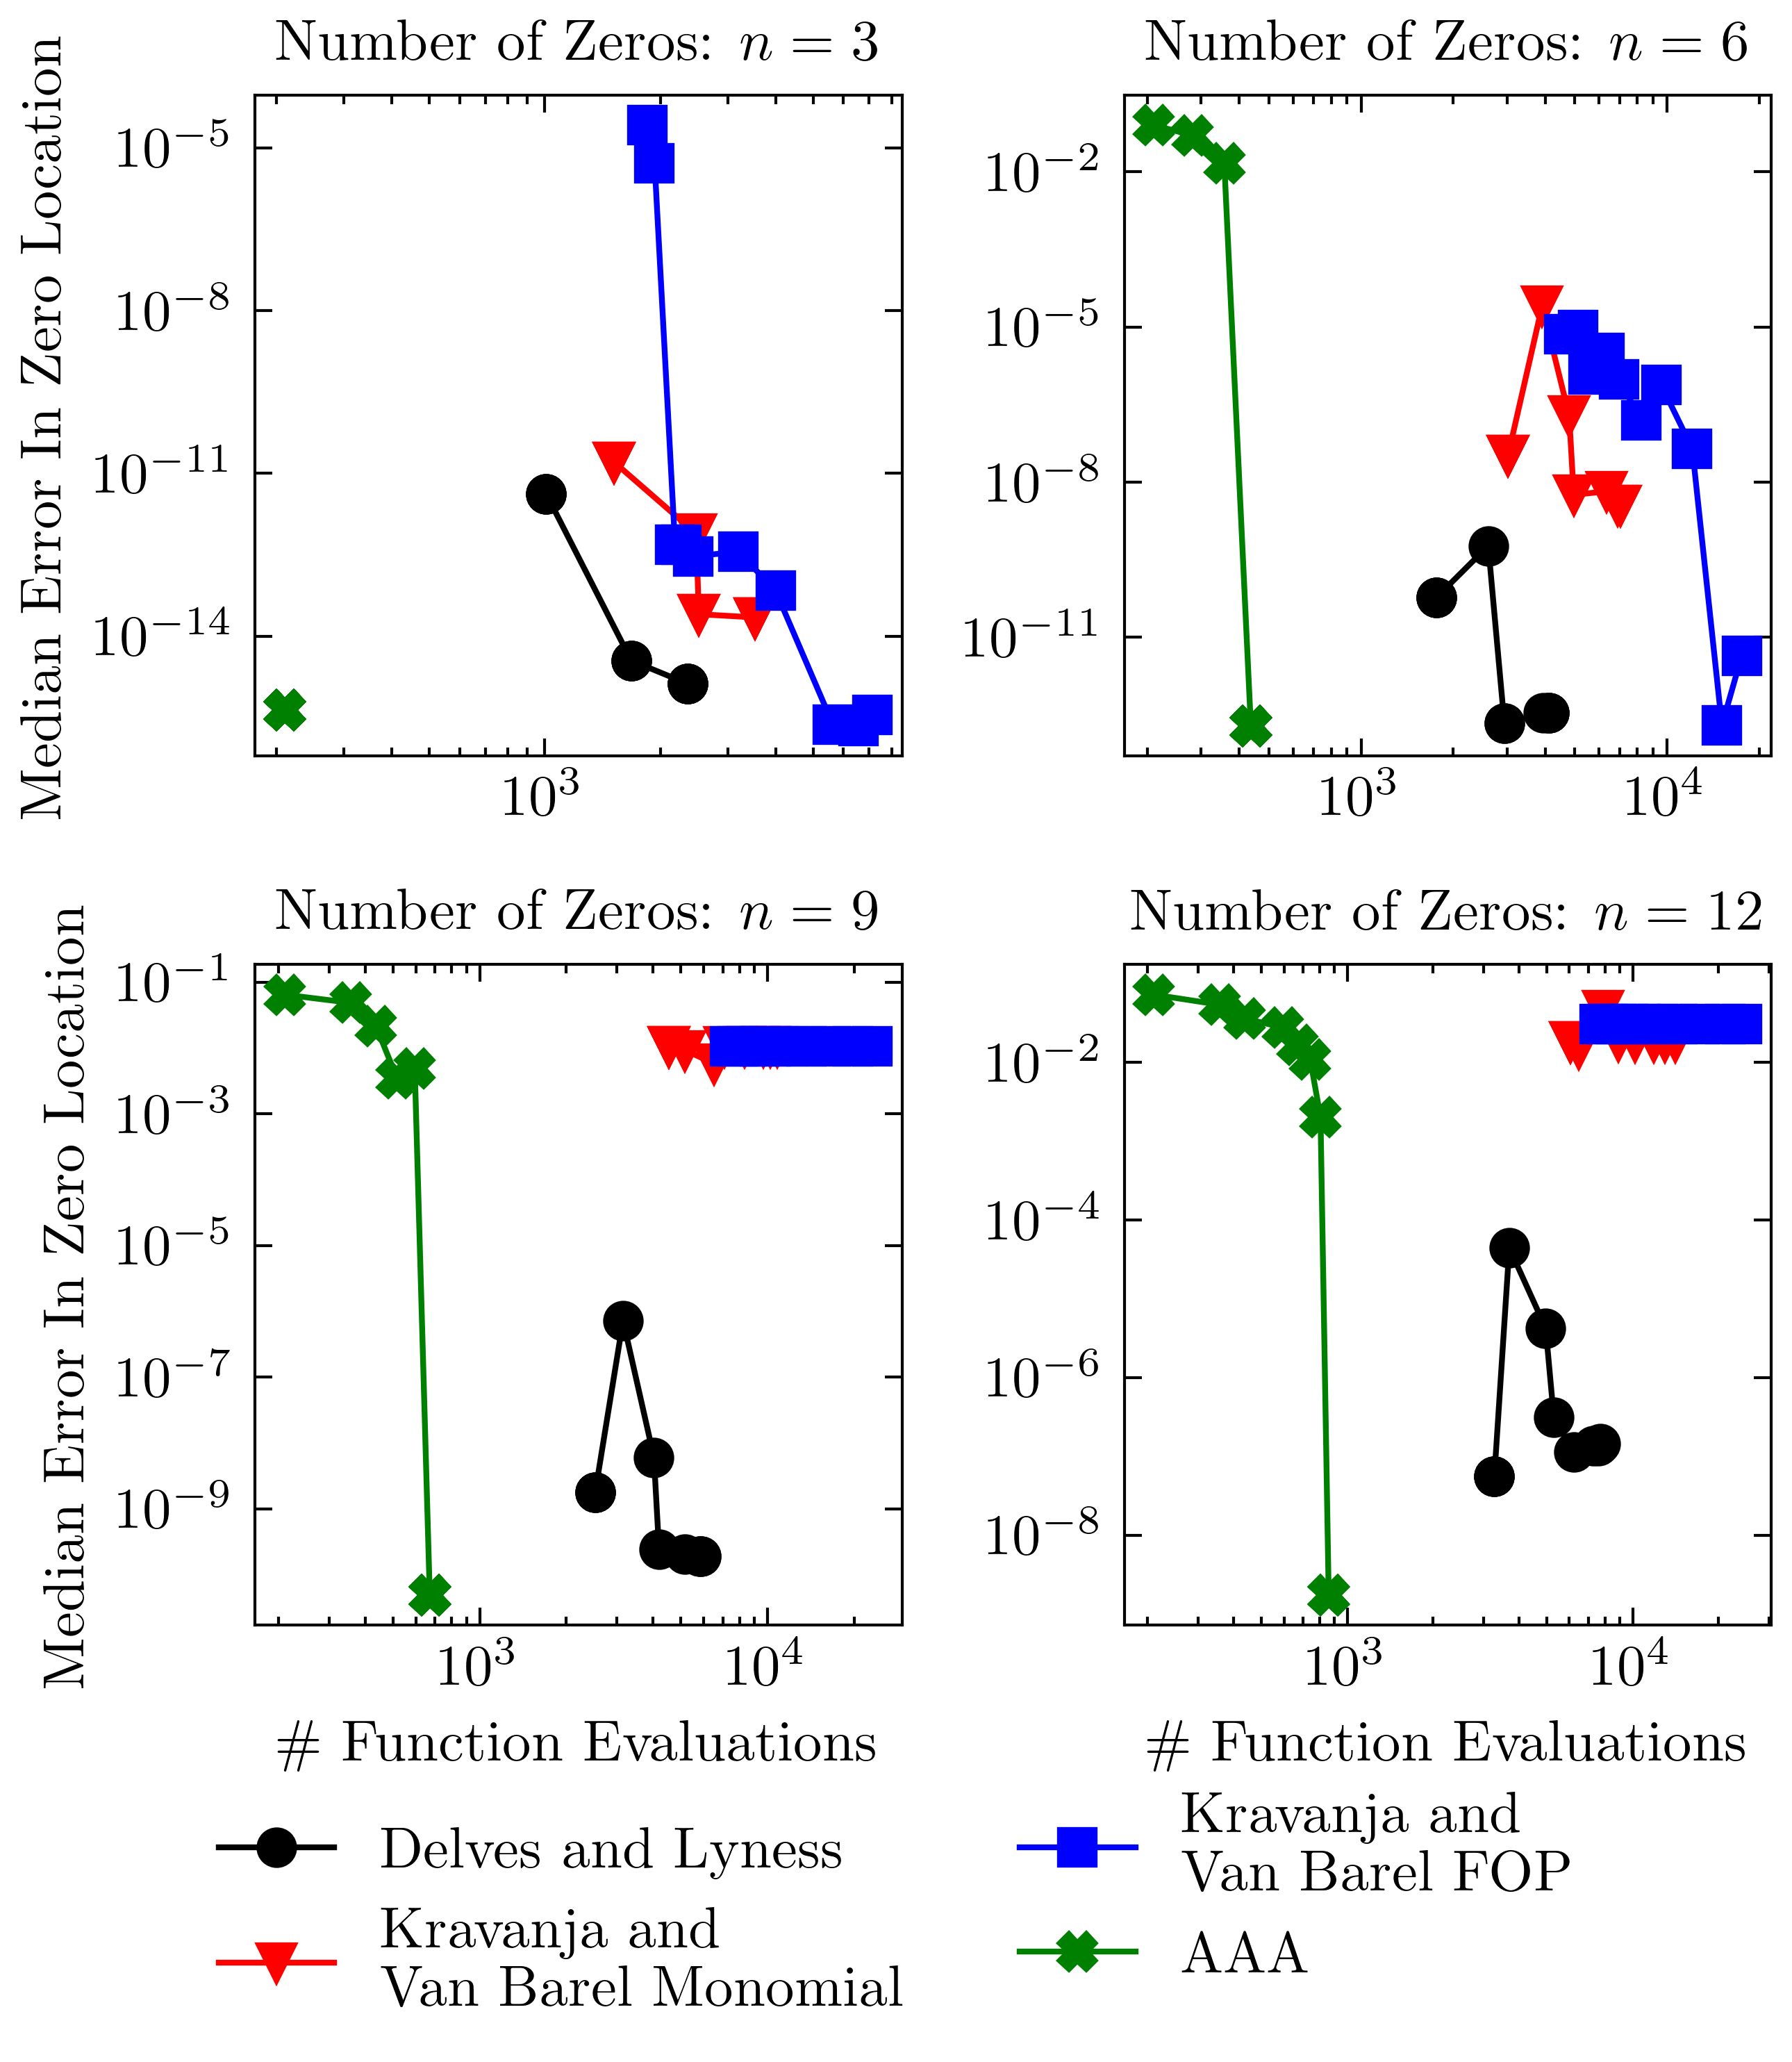

In [96]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(4.5, 4.5))
for i, n_zero in enumerate(n_zeros):
    ax = axs.ravel()[i]
    ax.loglog(
        delves_lyness_function_count[i],
        delves_lyness_error[i],
        "-o",
        label="Delves and Lyness",
    )
    ax.loglog(
        kravanja_van_barel_function_count[i],
        kravanja_van_barel_error[i],
        "-v",
        label="Kravanja and\nVan Barel Monomial",
    )
    ax.loglog(
        kravanja_van_barel_FOP_function_count[i],
        kravanja_van_barel_FOP_error[i],
        "-s",
        label="Kravanja and\nVan Barel FOP",
    )
    ax.loglog(
        aaa_function_count[i], np.asarray(aaa_error[i]) + 5e-17, "-X", label="AAA"
    )
    if i > 1:
        ax.set_xlabel(r"\# Function Evaluations")
    if i % 2 == 0:
        ax.set_ylabel("Median Error In Zero Location")
    ax.set_title(rf"Number of Zeros: $n={n_zero}$")
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize=10,
)
plt.tight_layout()
plt.savefig("figures/comparison.pdf")